```{index} disjunctive programming
```
```{index} single: application; scheduling
```
```{index} single: solver; cbc
```
```{index} single: Gantt charts
```

# Machine Scheduling

In [1]:
# install pyomo and select solver
import sys

SOLVER = "cbc"

if "google.colab" in sys.modules:
    !pip install highspy >/dev/null
    SOLVER = "appsi_highs"

## Problem description

"Which job should be done next?" is a question one face in modern life, whether for a busy student working on course assignments, a courier delivering packages, a server waiting on tables in a busy restaurant, a computer processing threads, or a machine on a complex assembly line. There are empirical answers to this question, among them "first in, first  out", "last  in, first out", or "shortest job first".  

What we consider in this notebook is the modeling finding solutions to this class of problem using optimization techniques. This notebook demonstrates the formulation of a model for scheduling a single machine scheduling using disjunctive programming in Pyomo. The problem is to schedule a set of jobs on a single machine given the release time, duration, and due time for each job. Date for the example problem is from Christelle Gueret, Christian Prins, Marc Sevaux, "Applications of Optimization with Xpress-MP," Chapter 5, Dash Optimization, 2000.

### Job data

The problem is to schedule a sequence of jobs for a single machine. The problem data presented as a Pandas dataframe where each row corresponds to a job. The dataframe in indexed the names of the jobs. The data for each job consists of the time when  it is released for machine processing, the duration of the job, and when the it is due. The objective is, if possible, to schedule the jobs on the machine to satisfy the due dates. If that is not possible, then the objective is to schedule the jobs to minimizing some measure of schedule "badness".

In [2]:
import pandas as pd

jobs = pd.DataFrame({
    'A': {'release': 2, 'duration': 5, 'due': 10},
    'B': {'release': 5, 'duration': 6, 'due': 21},
    'C': {'release': 4, 'duration': 8, 'due': 15},
    'D': {'release': 0, 'duration': 4, 'due': 10},
    'E': {'release': 0, 'duration': 2, 'due': 5},
    'F': {'release': 8, 'duration': 3, 'due': 15},
    'G': {'release': 9, 'duration': 2, 'due': 22},
}).T

jobs

,release,duration,due
A,2,5,10
B,5,6,21
C,4,8,15
D,0,4,10
E,0,2,5
F,8,3,15
G,9,2,22


### Schedule data

A schedule is also represented here by a Pandas dataframe indexed by job names. The columns indicate the start, finish, and the amount by each job is past due. The following cell creates a schedule when the jobs are executed in the order given by the `jobs` dataframe.

In [3]:
def schedule_jobs(jobs, seq):
    """
    Schedule a sequence of jobs based on their release times, durations, and due times.
    
    Args:
        jobs (DataFrame): Job information with columns "release", "duration", and "due".
        seq (DataFrame): A list of job indices representing the sequence in which the jobs will be scheduled.
        
    Return:
        A DataFrame containing schedule information, including "start", "finish", and "past" due times.
    """
    schedule = pd.DataFrame(index=jobs.index)
    t = 0
    for job in seq:
        t = max(t, jobs.loc[job]["release"])
        schedule.loc[job, "start"] = t
        t += jobs.loc[job, "duration"]
        schedule.loc[job, "finish"] = t
        schedule.loc[job, "past"] = max(0, t - jobs.loc[job, "due"])

    return schedule

schedule = schedule_jobs(jobs, jobs.index)
schedule

,start,finish,past
A,2.0,7.0,0.0
B,7.0,13.0,0.0
C,13.0,21.0,6.0
D,21.0,25.0,15.0
E,25.0,27.0,22.0
F,27.0,30.0,15.0
G,30.0,32.0,10.0


### Gantt chart

A traditional means of visualizing scheduling data in the form of a Gantt chart. The next cell presents a function `gantt` that plots a Gantt chart given jobs and schedule information. 

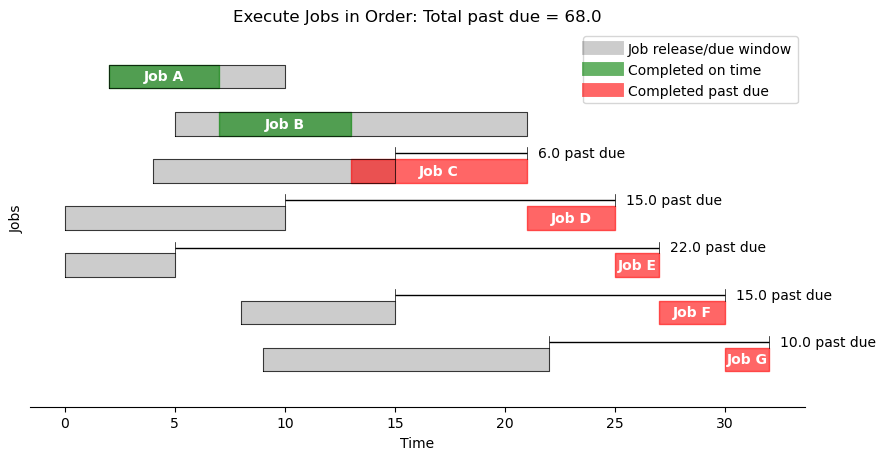

In [4]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

def gantt(jobs, schedule, title="Job Schedule"):
    """
    Plot a Gantt chart for a given job schedule.
    
    Args:
        jobs (DataFrame): Contains job release times and due times.
        schedule (DataFrame): Contains  job start times, finish times, and past due times.
        title (str, optional): Title of the Gantt chart. Defaults to "Job Schedule".
    """
    w = 0.25  # bar width
    fig, ax = plt.subplots(1, 1, figsize=(10, 0.7 * len(jobs.index)))

    for k, job in enumerate(jobs.index):
        r = jobs.loc[job, "release"]
        d = jobs.loc[job, "due"]
        s = schedule.loc[job, "start"]
        f = schedule.loc[job, "finish"]

        # Show job release-due window
        ax.fill_between([r, d], [-k - w, -k - w], [-k + w, -k + w], lw=1, color="k", alpha=0.2)
        ax.plot([r, r, d, d, r], [-k - w, -k + w, -k + w, -k - w, -k - w], lw=0.5, color="k")

        # Show job start-finish window
        color = 'g' if f <= d else 'r'
        ax.fill_between([s, f], [-k - w, -k - w], [-k + w, -k + w], color=color, alpha=0.6)
        ax.text((s + f) / 2.0, -k, "Job " + job, color="white", weight="bold", ha="center", va="center")

        # If past due
        if f > d:
            ax.plot([d]*2, [-k + w, -k + 2 * w], lw=0.5, color='k')
            ax.plot([f]*2, [-k + w, -k + 2 * w], lw=0.5, color='k')
            ax.plot([d, f], [-k + 1.5 * w]*2, solid_capstyle='butt', lw=1, color="k")
            ax.text(f + 0.5, -k + 1.5 * w, f"{schedule.loc[job, 'past']} past due", va="center")

    total_past_due = schedule["past"].sum()
    ax.set_ylim(-len(jobs.index), 1)
    ax.set_title(f'{title}: Total past due = {total_past_due}')
    ax.set_xlabel('Time')
    ax.set_ylabel('Jobs')
    ax.set_yticks([])  # range(len(jobs.index)), jobs.index)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['top'].set_visible(False)

    custom_lines = [Line2D([0], [0], c='k', lw=10, alpha=0.2),
                    Line2D([0], [0], c='g', lw=10, alpha=0.6),
                    Line2D([0], [0], c='r', lw=10, alpha=0.6)]
    ax.legend(custom_lines, ['Job release/due window', 
                             'Completed on time', 
                             'Completed past due'])
        
gantt(jobs, schedule, "Execute Jobs in Order")

## Empirical Scheduling

To provide a comparison to scheduling with optimization models, the following cells implement two well known and accepted empirical rules for scheduling jobs on a single machine:

* First in, first out (FIFO)
* Earliest due data (EDD)

### First-in, first-out (FIFO)

One of the most common scheduling rules is to execute jobs in the order they are released for processing, in other words "first-in, first-out" (FIFO). The following cell creates a Pandas dataframe  is indexed by job names. The start time, finish time, and, if past due, the amount by which the job is past due.


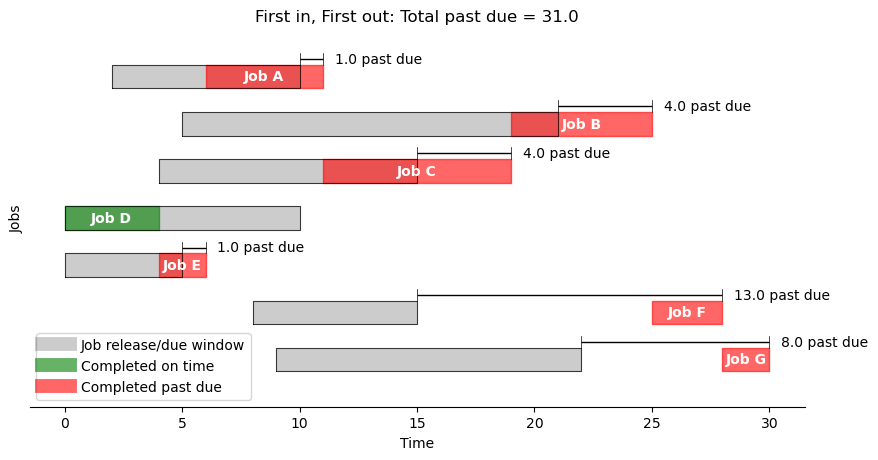

In [5]:
fifo = schedule_jobs(jobs, jobs.sort_values(by="release").index)
gantt(jobs, fifo, "First in, First out")

### Earliest due date (EDD)

When due dates are known, a common scheduling rule is to prioritize jobs by due date. This strategy will be familiar to any student deciding which homework assignment should to work on next.

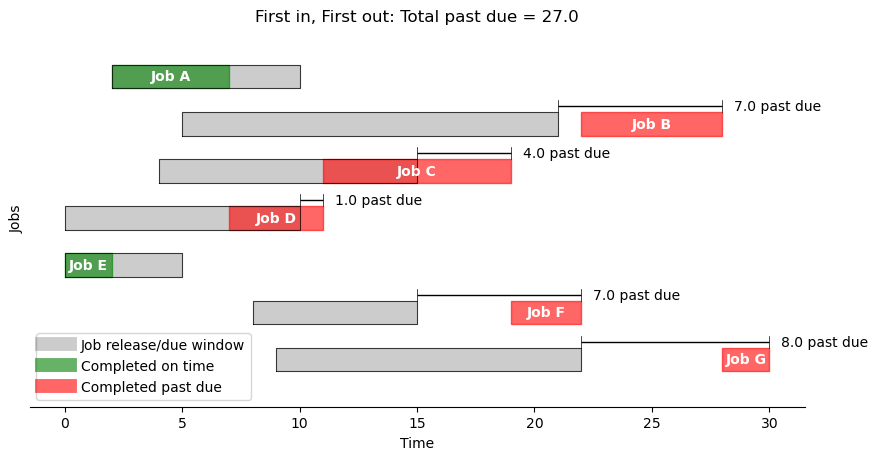

In [6]:
edd = schedule_jobs(jobs, jobs.sort_values(by="due").index)
gantt(jobs, edd, "First in, First out")

## Optimal Scheduling

The modeling starts by defining the problem data.

| Symbol | Description 
|:---- | :--- 
| release$_j$ | when job $j$ is available
| duration$_j$ | how long job $j$ 
| due$_j$ | when job $j$ is due 

The essential decision variable is the time at which the job starts processing.

| Symbol | Description
|:---- | :--- 
| start$_j$ | when job $j$ starts
| finish$_j$ | when job $j$ finishes
| past$_j$ | how long job $j$ is past due

Depending on application and circumstances, various objectives can be considered. Suitable objectives include the total number of late jobs, the longest past due interval, or the sum of all past due intervals. The following Pyomo model minimizes the sum of past due intervals, that is

$$
\min \sum_j \text{past}_j
$$

Constraints describe the required logical relationships among the decision variables. For example, a job cannot start until it is released for processing

$$
\begin{align*}
\text{start}_{j} & \geq \text{release}_{j}\\
\end{align*}
$$

Once started, machine processing continues until the job is finished. The finish time for each job is compared to the due time, and any past due interval is stored the $\text{past}_j$ decision variable. 

$$
\begin{align*}
\text{finish}_j & = \text{start}_j + \text{duration}_j \\
\text{past}_{j} & \geq \text{finish}_j - \text{due}_{j} \\
\text{past}_{j} & \geq 0
\end{align*}
$$

The final set of constraints require that no pair of jobs be operating on the same machine at the same time. For this purpose, we consider each unique pair ($i$, $j$) where the constraint $i < j$ to imposed to avoid considering the same pair twice. Then for any unique pair $i$ and $j$,  either $i$ finishes before $j$ starts, or $j$ finishes before $i$ starts. This is expressed as the family of disjunctions 

$$
\begin{align*}
\begin{bmatrix}
\text{finish}_i \leq \text{start}_j
\end{bmatrix}
& \veebar
\begin{bmatrix}
\text{finish}_j \leq \text{start}_i
\end{bmatrix}
& \forall i < j
\end{align*}
$$

This model and constraints can be directly translated to Pyomo.

In [7]:
import pyomo.environ as pyo
import pyomo.gdp as gdp

def build_model(jobs):

    m = pyo.ConcreteModel('Job machine scheduling')

    m.JOBS = pyo.Set(initialize=jobs.index)
    m.PAIRS = pyo.Set(initialize=m.JOBS * m.JOBS, filter = lambda m, i, j: i < j)

    m.start = pyo.Var(m.JOBS, domain=pyo.NonNegativeReals, bounds=(0, 300))
    m.finish = pyo.Var(m.JOBS, domain=pyo.NonNegativeReals, bounds=(0, 300))
    m.past = pyo.Var(m.JOBS, domain=pyo.NonNegativeReals, bounds=(0, 300))

    @m.Constraint(m.JOBS)
    def job_release(m, job):
        return m.start[job] >= jobs.loc[job, "release"]
    
    @m.Constraint(m.JOBS)
    def job_duration(m, job):
        return m.finish[job] == m.start[job] + jobs.loc[job, "duration"]

    @m.Constraint(m.JOBS)
    def past_due_constraint(m, job):
        return m.past[job] >= m.finish[job] - jobs.loc[job, "due"]

    @m.Disjunction(m.PAIRS, xor=True)
    def machine_deconflict(m, job_a, job_b):
        return [m.finish[job_a] <= m.start[job_b],
                m.finish[job_b] <= m.start[job_a]]
    
    @m.Objective(sense=pyo.minimize)
    def minimize_past(m):
        return sum(m.past[job] for job in m.JOBS)

    pyo.TransformationFactory("gdp.bigm").apply_to(m)
    return m

def solve_model(m, solver_name=SOLVER):
    solver = pyo.SolverFactory(solver_name)
    solver.solve(m)
    schedule = pd.DataFrame({
        "start" : {job: m.start[job]() for job in m.JOBS},
        "finish" : {job: m.finish[job]() for job in m.JOBS},
        "past" : {job: m.past[job]() for job in m.JOBS},
    })
    return schedule
    
model = build_model(jobs)
schedule = solve_model(model)

display(schedule)

,start,finish,past
A,6.0,11.0,1.0
B,14.0,20.0,0.0
C,22.0,30.0,15.0
D,2.0,6.0,0.0
E,0.0,2.0,0.0
F,11.0,14.0,0.0
G,20.0,22.0,0.0


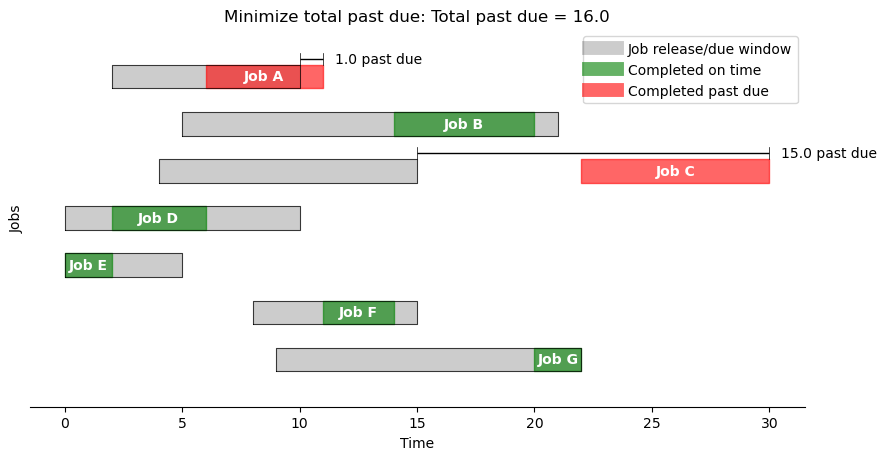

In [8]:
gantt(jobs, schedule, "Minimize total past due")